## import modules

In [1]:
# Import basic modules
# More modules will be imported before the corresponding function
# import logging # logger = logging.getLogger(__name__)
import math
import os
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") # Ignore some annoying warnings
from datetime import datetime

# Import module for EMD decomposition
# It is the EMD-signal module with different name to import
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation #For module 'PyEMD', please use 'pip install EMD-signal' instead.

# Import module for sample entropy
from sampen import sampen2

# Import modules for LSTM prediciton
# Sklearn
from sklearn.preprocessing import MinMaxScaler # Normalization
from sklearn.metrics import r2_score # R2
from sklearn.metrics import mean_squared_error # MSE
from sklearn.metrics import mean_absolute_error # MAE
from sklearn.metrics import mean_absolute_percentage_error # MAPE
# Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.layers import GRU,Flatten
#from tcn import TCN # pip install keras-tcn

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import plot_model # To use plot_model, you need to install software graphviz
from tensorflow.python.client import device_lib

# Statistical tests
from statsmodels.tsa.stattools import adfuller # adf_test
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test # LB_test
from statsmodels.stats.stattools import jarque_bera as jb_test # JB_test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot_acf_pacf

from sklearn.preprocessing import StandardScaler

In [2]:
#import dataset
data = pd.read_excel('/Users/tiantianzhang/Desktop/patient/p4/p4.xlsx', usecols=[2,5])
#data = data.reindex(index = data.index[::-1])

In [3]:
data.head()

,ReadingDt,SensorGLU
0,2000-02-23,40
1,2000-02-23,40
2,2000-02-23,40
3,2000-02-23,45
4,2000-02-23,49


In [4]:
CGMS = pd.Series(data['SensorGLU'])
CGMS

0       40
1       40
2       40
3       45
4       49
        ..
1775    82
1776    73
1777    66
1778    40
1779    40
Name: SensorGLU, Length: 1780, dtype: int64

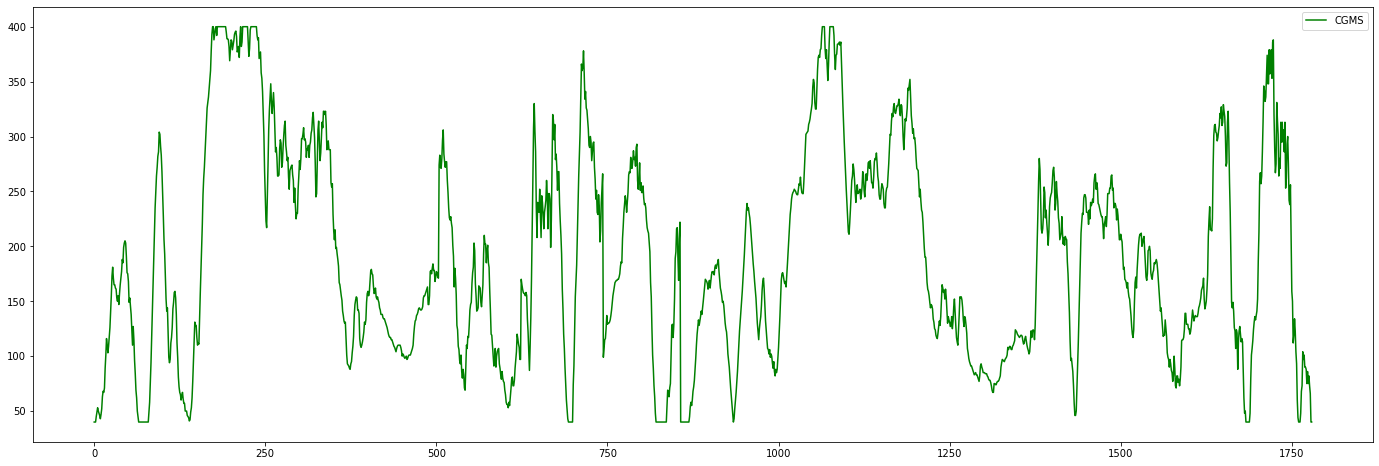

In [5]:
# PLOTTING 
plt.figure(figsize=(24,8))
plt.plot( CGMS, 'g', label = 'CGMS')
plt.legend(loc = 'upper right')
plt.show()

In [6]:
# Model variables
# -------------------------------
# Mainly determine the decomposition method 
MODE = 'emd' 
# Integration form only effective after integration

# 2. EMD decompose data

In [7]:
# 3.Decomposition, Sample entropy, Re-decomposition, and Integration
#==============================================================================================

# EMD decomposition
# -------------------------------
# Decompose adaptively and plot function
# Residue is named the last IMF
# Declare MODE by declare_vars first
def emd_decom(s1,trials=10,re_decom=False,re_imf=0,draw=True): 
    # Check input
    #dataset,file_name = check_dataset(series,input_form='series') # include check_vars()
    #series = series.values
    series = s1.values
    #series = s1

    # Initialization
    print('%s decomposition is running.'%str.upper(MODE))
    if MODE == 'emd':
        decom = EMD()
    elif MODE == 'eemd':
        decom = EEMD()
    elif MODE == 'ceemdan':
        decom = CEEMDAN()
    else: 
        raise ValueError('MODE must be emd, eemd, ceemdan when EMD decomposing.')

    # Decompose
    decom.trials = trials # Number of the white noise input
    imfs_emd = decom(series)
    imfs_num = np.shape(imfs_emd)[0]

    if draw:
        # Plot original data
        series_index = range(len(series))
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series_index, series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(series_index, imfs_emd[i, :], color='#F27F19')
            plt.ylabel(str.upper(MODE)+'-IMF'+str(i))
 
        # Save figure
        #fig.align_labels()
        #plt.tight_layout()
        #if file_name == '':
            #if (re_decom==False): plt.savefig(FIGURE_PATH+file_name+str.upper(MODE)+' Result.svg', bbox_inches='tight')
            #else: plt.savefig(FIGURE_PATH+'IMF'+str(re_imf)+' '+str.upper(MODE)+' Re-decomposition Result.svg', bbox_inches='tight')
        plt.show()
    
    # Save data
    imfs_df = pd.DataFrame(imfs_emd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]
    #if file_name == '':
        #if (re_decom==False): 
            #pd.DataFrame.to_csv(imfs_df,PATH+file_name+MODE+'_data.csv')
            #print(str.upper(MODE)+' finished, check the dataset: ',PATH+file_name+MODE+'_data.csv')
    #PATH = '/Users/tiantianzhang/Desktop/patient/p4/'
    #file_name = 'p4_imfs'
    #pd.DataFrame.to_csv(imfs_df,PATH+file_name+MODE+'_data.csv')
    #print(str.upper(MODE)+' finished, check the dataset: ',PATH+file_name+MODE+'_data.csv')



    return imfs_df # pd.DataFrame

In [8]:
MODE

'emd'

In [42]:
CGMS

0       40
1       40
2       40
3       45
4       49
        ..
1775    82
1776    73
1777    66
1778    40
1779    40
Name: SensorGLU, Length: 1780, dtype: int64

EMD decomposition is running.


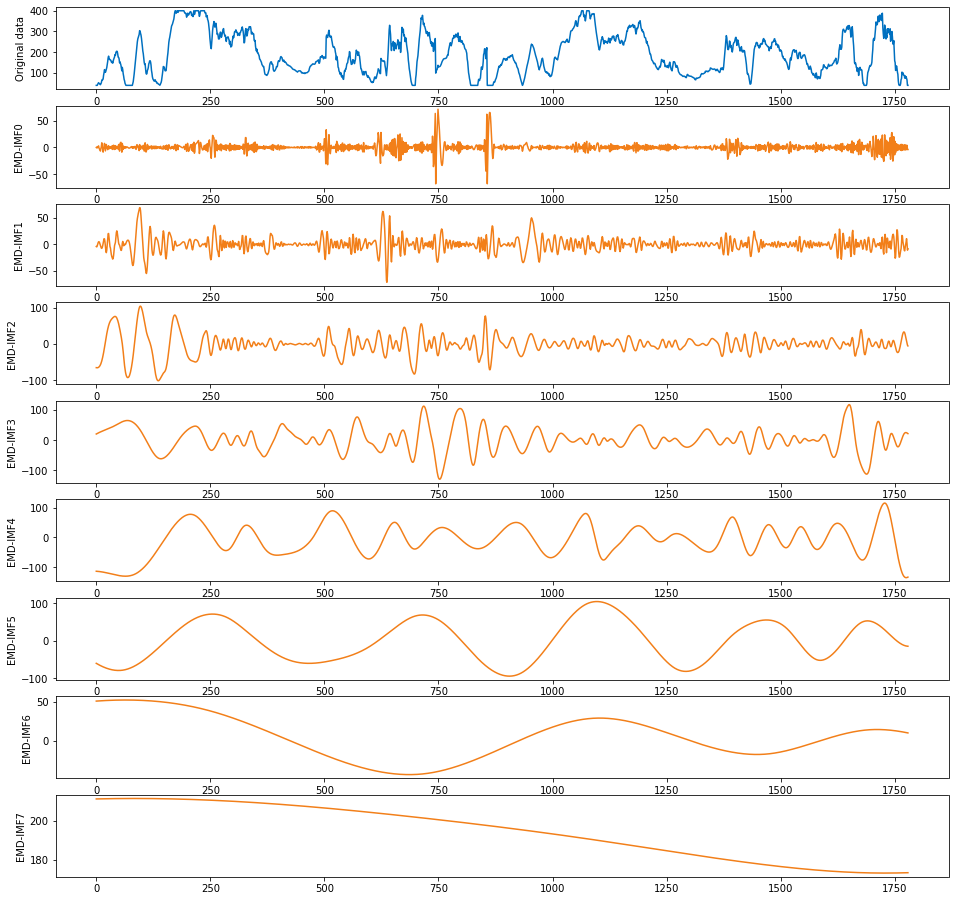

EMD finished, check the dataset:  /Users/tiantianzhang/Desktop/patient/p4/p4_imfsemd_data.csv


In [9]:
imfs = emd_decom(CGMS)

lst1 = ['imf0','imf1','imf2','imf3','imf4','imf5','imf6','imf7']
denoise_1 = ['imf1','imf2','imf3','imf4','imf5','imf6','imf7']
denoise_2 = ['imf2','imf3','imf4','imf5','imf6','imf7']
imfs['sum1'] = imfs[denoise_1].sum(axis = 1)
imfs['sum2'] = imfs[denoise_2].sum(axis = 1)
imfs['ogrinial data']= imfs[lst1].sum(axis = 1)
imfs

plt.figure(figsize = (20,8))
plt.plot(CGMS,'red')
#plt.plot(imfs['sum1'],'blue')
#plt.plot(imfs['sum2'],'green')

# 3. Single-LSTM

In [11]:
CGMS_df = pd.DataFrame(data['SensorGLU'])
CGMS_df

,SensorGLU
0,40
1,40
2,40
3,45
4,49
...,...
1775,82
1776,73
1777,66
1778,40


In [12]:
def LSTM_Data_Precesing(df,mem_his_days,pre_days):
    #df.dropna(inplace=True)
    #df.sort_index(inplace=True)

    df['label'] = df.iloc[:][0:].shift(-pre_days)

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    sca_X = scaler.fit_transform(df.iloc[:,:-1])
    #print(type(sca_X))

    from collections import deque
    deq = deque(maxlen=mem_his_days)

    X = []
    for i in sca_X:
        deq.append(list(i))
        if len(deq)==mem_his_days:
            X.append(list(deq))

    X_lately = X[-pre_days:]
    X = X[:-pre_days]

    y = scaler.fit_transform(df.iloc[:,-1:])[mem_his_days-1:-pre_days]

    import numpy as np
    X = np.array(X)

    return X,y,X_lately

In [13]:
X,y,X_lately = LSTM_Data_Precesing(CGMS_df,20,1)

In [14]:
print(len(X))
print(len(y))
print(len(X_lately))

1760
1760
1


In [15]:
from sklearn.model_selection import train_test_split
X_train = X[0:1500]
X_test = X[1500:]
y_train = y[0:1500]
y_test = y[1500:]

In [54]:
X_train

array([[[-1.56714547],
        [-1.56714547],
        [-1.56714547],
        ...,
        [-0.93190003],
        [-0.77569213],
        [-0.83817529]],

       [[-1.56714547],
        [-1.56714547],
        [-1.51507617],
        ...,
        [-0.77569213],
        [-0.83817529],
        [-0.91107231]],

       [[-1.56714547],
        [-1.51507617],
        [-1.47342073],
        ...,
        [-0.83817529],
        [-0.91107231],
        [-0.84858915]],

       ...,

       [[ 0.28652155],
        [ 0.16155524],
        [ 0.16155524],
        ...,
        [-0.4736902 ],
        [-0.55700108],
        [-0.66113968]],

       [[ 0.16155524],
        [ 0.16155524],
        [ 0.21362453],
        ...,
        [-0.55700108],
        [-0.66113968],
        [-0.73403669]],

       [[ 0.16155524],
        [ 0.21362453],
        [ 0.1719691 ],
        ...,
        [-0.66113968],
        [-0.73403669],
        [-0.76527827]]])

In [16]:
#pre_days = 1
# mem_days = [5,10,15]
# lstm_layers = [1,2,3]
# dense_layers = [1,2,3]
# units = [16,32]
                
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(1,input_shape=X.shape[1:],activation='sigmoid',return_sequences=True))
#model.add(Dropout(0.1))
                

model.add(LSTM(10,activation='tanh'))
#model.add(Dropout(0.1))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

2022-06-20 15:19:41.764039: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-20 15:19:41.764524: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 1)             12        
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 503
Trainable params: 503
Non-trainable params: 0
_________________________________________________________________


In [18]:
history_LSTM=model.fit(X_train,y_train,batch_size=32,epochs=50,validation_data=(X_test,y_test))

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 15:19:43.356076: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_3636_4121' and '__inference___backward_standard_lstm_3636_4121_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_4659' both implement 'lstm_36216590-5d90-4537-a53f-6d14efe0f37d' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 1.0169

2022-06-20 15:19:46.490809: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_5220' and '__inference_standard_lstm_5109_specialized_for_sequential_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_5438' both implement 'lstm_e336270d-55de-4767-8c5c-b92b65e39f8d' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 1.0200 - val_loss: 0.8915
Epoch 2/50
1500/1500 [==============================] - 1s 963us/sample - loss: 0.9540 - val_loss: 0.7910
Epoch 3/50
1500/1500 [==============================] - 1s 994us/sample - loss: 0.6384 - val_loss: 0.6536
Epoch 4/50
1500/1500 [==============================] - 1s 975us/sample - loss: 0.3988 - val_loss: 0.5290
Epoch 5/50
1500/1500 [==============================] - 1s 974us/sample - loss: 0.3328 - val_loss: 0.5162
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2877 - val_loss: 0.3912
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/sample - loss: 0.2360 - val_loss: 0.2684
Epoch 8/50
1500/1500 [==============================] - 1s 964us/sample - loss: 0.1998 - val_loss: 0.2070
Epoch 9/50
1500/1500 [==============================] - 1s 973us/sample - loss: 0.1808 - val_loss: 0.1961
Epoch 10/50
1500/1500 [==============================] - 2s 1ms

In [19]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

2022-06-20 15:23:41.146957: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_11602' and '__inference_standard_lstm_11491_specialized_for_sequential_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_11793' both implement 'lstm_bca09ec2-1037-43ce-8de3-5e5b839a72a2' but their signatures do not match.


In [20]:
scaler = StandardScaler()
sca_X = scaler.fit_transform(CGMS_df.iloc[:,:-1])

In [21]:
trainPredict = scaler.inverse_transform(trainPredict)
y_train = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
y_test = scaler.inverse_transform(y_test)

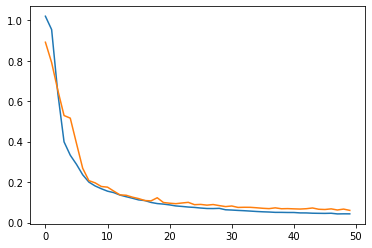

In [59]:
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])

In [23]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 19.25
Test RMSE: 23.51


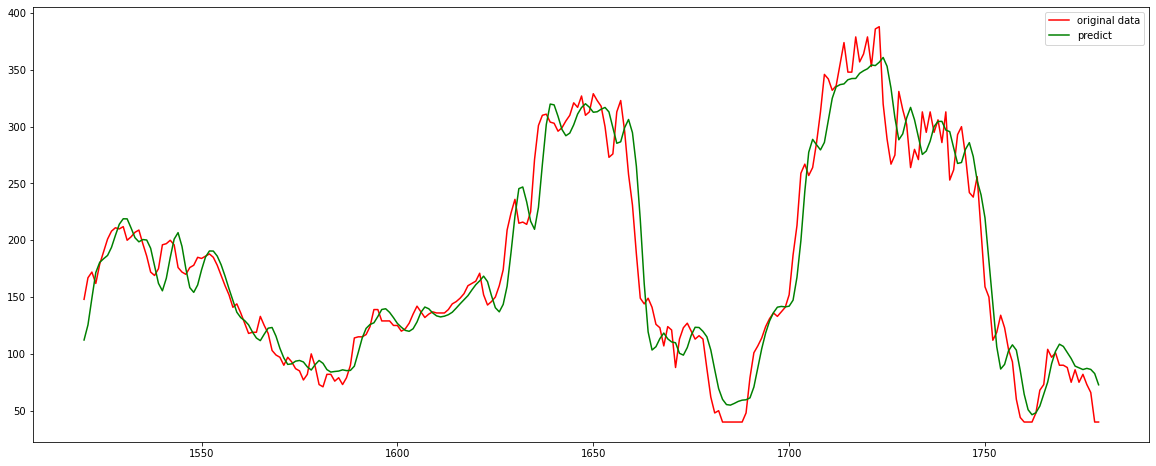

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,8))
df_time = CGMS_df.index[-len(y_test):]
plt.plot(df_time,y_test,color='red',label='original data')
plt.plot(df_time,testPredict,color='green',label='predict')
plt.legend()
plt.show()

# Multi-LSTM

In [25]:
imfs

,imf0,imf1,imf2,imf3,imf4,imf5,imf6,imf7
0,-0.102581,-3.943954,-64.796876,20.384439,-114.061662,-59.733687,51.107259,211.147062
1,0.765426,-4.594334,-65.083754,21.215467,-114.166665,-60.438311,51.149554,211.152617
2,-0.921463,-2.873972,-65.162935,22.027034,-114.285554,-61.132448,51.191231,211.158107
3,0.963772,0.067195,-65.010775,22.818457,-114.418547,-61.815923,51.232288,211.163534
4,1.559780,3.057513,-64.595093,23.590496,-114.565753,-62.488564,51.272724,211.168897
...,...,...,...,...,...,...,...,...
1775,4.152286,4.593890,13.515932,25.066089,-135.779070,-13.518668,10.497409,173.472132
1776,-3.994592,10.932561,6.999539,24.640384,-135.680262,-13.756998,10.380634,173.478735
1777,3.957909,2.387654,1.262856,23.888460,-135.298598,-13.946168,10.262413,173.485473
1778,-3.964227,-10.831149,-2.968564,22.877832,-134.662310,-14.086686,10.142759,173.492344


In [26]:
def LSTM_model(df,mem_his_days,pre_days,string):
    X0,y0,X0_lately = LSTM_Data_Precesing(df,20,1)
    
    X0_train = X0[0:1500]
    X0_test = X0[1500:]
    y0_train = y0[0:1500]
    y0_test = y0[1500:]
    
    
    model = Sequential()
    model.add(LSTM(1,input_shape=X0.shape[1:],activation='sigmoid',return_sequences=True))
    #model.add(Dropout(0.1))
                
    model.add(LSTM(10,activation='tanh'))
    #model.add(Dropout(0.1))
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam',loss='mse')
    
    model.fit(X0_train,y0_train,batch_size=32,epochs=50,validation_data=(X0_test,y0_test))
    
    
    trainPredict0 = model.predict(X0_train)
    testPredict0 = model.predict(X0_test)
    
    scaler = StandardScaler()
    sca_X0 = scaler.fit_transform(df[[string]])
    
    trainPredict0 = scaler.inverse_transform(trainPredict0)
    y0_train = scaler.inverse_transform(y0_train)
    testPredict0 = scaler.inverse_transform(testPredict0)
    y0_test = scaler.inverse_transform(y0_test)
    
    trainScore0 = math.sqrt(mean_squared_error(y0_train, trainPredict0))
    print('Train RMSE: %.2f' % (trainScore0))

    # TEST RMSE
    testScore0 = math.sqrt(mean_squared_error(y0_test, testPredict0))
    print('Test RMSE: %.2f' % (testScore0))
    
    plt.figure(figsize=(20,8))
    df_time = df.index[-len(y0_test):]
    plt.plot(df_time,y0_test,color='red',label='original data')
    plt.plot(df_time,testPredict0,color='green',label='predict')
    plt.show()
    return testPredict0

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 15:28:54.701185: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_24793_25278' and '__inference___backward_standard_lstm_24793_25278_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_25816' both implement 'lstm_9853299d-58ff-4498-a76c-8ab5637807ee' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.9616

2022-06-20 15:28:57.624522: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_26377' and '__inference_standard_lstm_26266_specialized_for_sequential_2_lstm_5_StatefulPartitionedCall_at___inference_distributed_function_26595' both implement 'lstm_f0335aca-30bb-4bd5-8cbc-ceb6f4cd7afb' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 1.0188 - val_loss: 0.9545
Epoch 2/50
1500/1500 [==============================] - 1s 950us/sample - loss: 1.0177 - val_loss: 0.9589
Epoch 3/50
1500/1500 [==============================] - 1s 957us/sample - loss: 1.0172 - val_loss: 0.9576
Epoch 4/50
1500/1500 [==============================] - 1s 974us/sample - loss: 1.0163 - val_loss: 0.9581
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 1.0150 - val_loss: 0.9592
Epoch 6/50
1500/1500 [==============================] - 1s 982us/sample - loss: 1.0146 - val_loss: 0.9571
Epoch 7/50
1500/1500 [==============================] - 1s 972us/sample - loss: 1.0128 - val_loss: 0.9600
Epoch 8/50
1500/1500 [==============================] - 1s 971us/sample - loss: 1.0111 - val_loss: 0.9617
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 1.0095 - val_loss: 0.9603
Epoch 10/50
1500/1500 [==============================] - 1s 963

2022-06-20 15:30:41.672502: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_32648' and '__inference_standard_lstm_32648_specialized_for_sequential_2_lstm_5_StatefulPartitionedCall_at___inference_distributed_function_32950' both implement 'lstm_69205f99-8ac4-4903-a22c-ef25176b2f5e' but their signatures do not match.


Train RMSE: 7.90
Test RMSE: 8.49


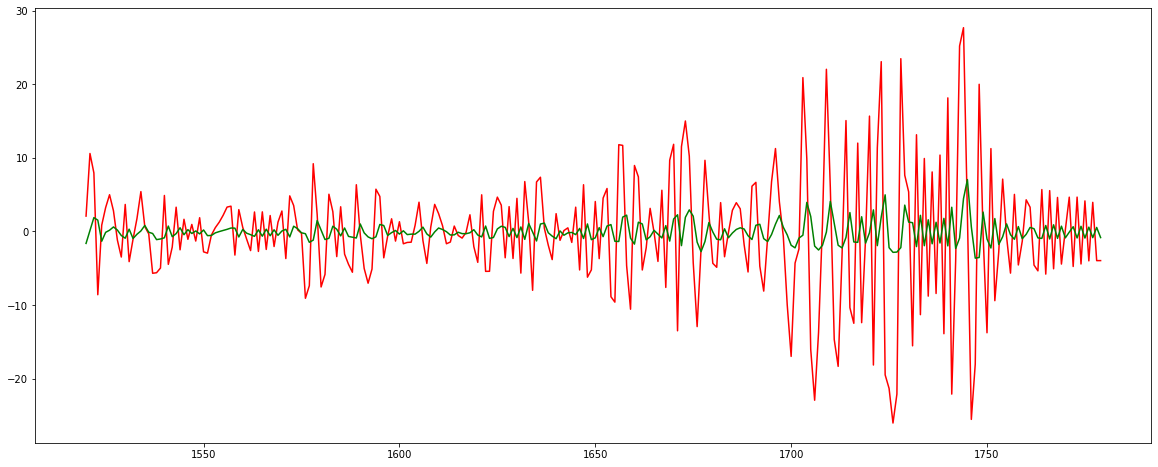

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 15:30:44.323977: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_36397_36579' and '__inference___backward_standard_lstm_36692_37177_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_37715' both implement 'lstm_869ac628-b8ce-40e6-afe1-9aa3f4f5ceed' but their signatures do not match.


1472/1500 [============================>.] - ETA: 0s - loss: 1.0821

2022-06-20 15:30:47.898475: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_38165' and '__inference_standard_lstm_38165_specialized_for_sequential_3_lstm_7_StatefulPartitionedCall_at___inference_distributed_function_38494' both implement 'lstm_f69ef451-a8ff-43c9-b382-141ec9c65c01' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 1.0868 - val_loss: 0.5945
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 1.0732 - val_loss: 0.5942
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 1.0679 - val_loss: 0.5939
Epoch 4/50
1500/1500 [==============================] - 10s 7ms/sample - loss: 1.0572 - val_loss: 0.5942
Epoch 5/50
1500/1500 [==============================] - 19s 13ms/sample - loss: 1.0416 - val_loss: 0.5951
Epoch 6/50
1500/1500 [==============================] - 21s 14ms/sample - loss: 1.0081 - val_loss: 0.5997
Epoch 7/50
1500/1500 [==============================] - 17s 11ms/sample - loss: 0.9460 - val_loss: 0.6185
Epoch 8/50
1500/1500 [==============================] - 35s 23ms/sample - loss: 0.8789 - val_loss: 0.6314
Epoch 9/50
1500/1500 [==============================] - 25s 17ms/sample - loss: 0.8262 - val_loss: 0.6346
Epoch 10/50
1500/1500 [==============================] - 28s 19m

2022-06-20 15:41:37.488129: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_44547' and '__inference_standard_lstm_44547_specialized_for_sequential_3_lstm_7_StatefulPartitionedCall_at___inference_distributed_function_44849' both implement 'lstm_20c51c8d-1762-41d2-8ec3-e2505b47337b' but their signatures do not match.


Train RMSE: 5.00
Test RMSE: 4.99


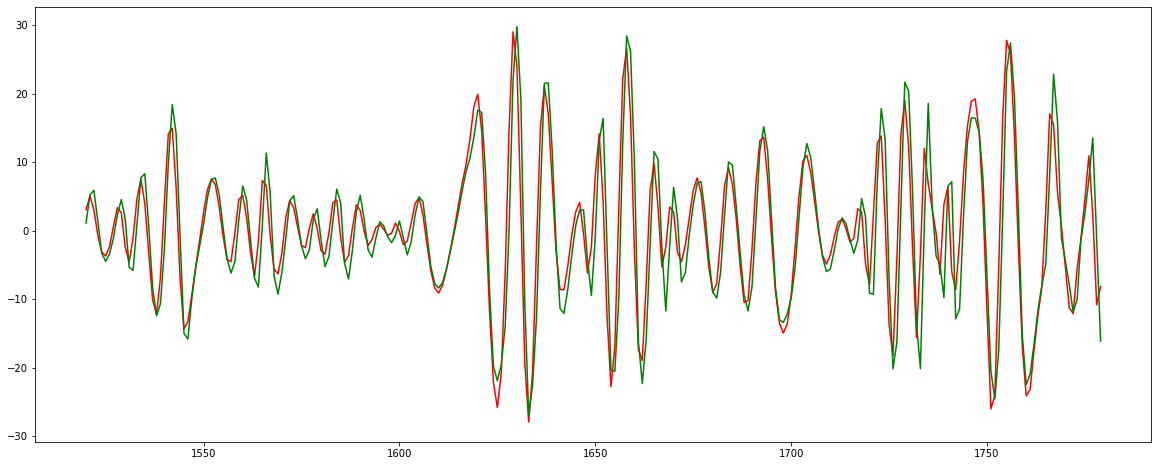

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 15:41:39.801938: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_48591_49076' and '__inference___backward_standard_lstm_48591_49076_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_49614' both implement 'lstm_d359807c-8f65-4ea8-a10d-3e17d95e744a' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 1.1092

2022-06-20 15:41:42.924019: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_50064_specialized_for_sequential_4_lstm_9_StatefulPartitionedCall_at___inference_distributed_function_50393' and '__inference_standard_lstm_50064' both implement 'lstm_a57a9f24-64c1-4b48-ad82-f2a050237eeb' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 1.0908 - val_loss: 0.2124
Epoch 2/50
1500/1500 [==============================] - 1s 969us/sample - loss: 1.0163 - val_loss: 0.2149
Epoch 3/50
1500/1500 [==============================] - 1s 962us/sample - loss: 0.8599 - val_loss: 0.1876
Epoch 4/50
1500/1500 [==============================] - 1s 989us/sample - loss: 0.6370 - val_loss: 0.1814
Epoch 5/50
1500/1500 [==============================] - 1s 963us/sample - loss: 0.4744 - val_loss: 0.1729
Epoch 6/50
1500/1500 [==============================] - 1s 965us/sample - loss: 0.3817 - val_loss: 0.1446
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.3187 - val_loss: 0.1334
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2785 - val_loss: 0.1233
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2408 - val_loss: 0.1046
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/s

2022-06-20 15:45:34.921116: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_56446' and '__inference_standard_lstm_56446_specialized_for_sequential_4_lstm_9_StatefulPartitionedCall_at___inference_distributed_function_56748' both implement 'lstm_56cf560e-6a6b-4948-99f0-7e753cd2c8f0' but their signatures do not match.


Train RMSE: 4.47
Test RMSE: 3.96


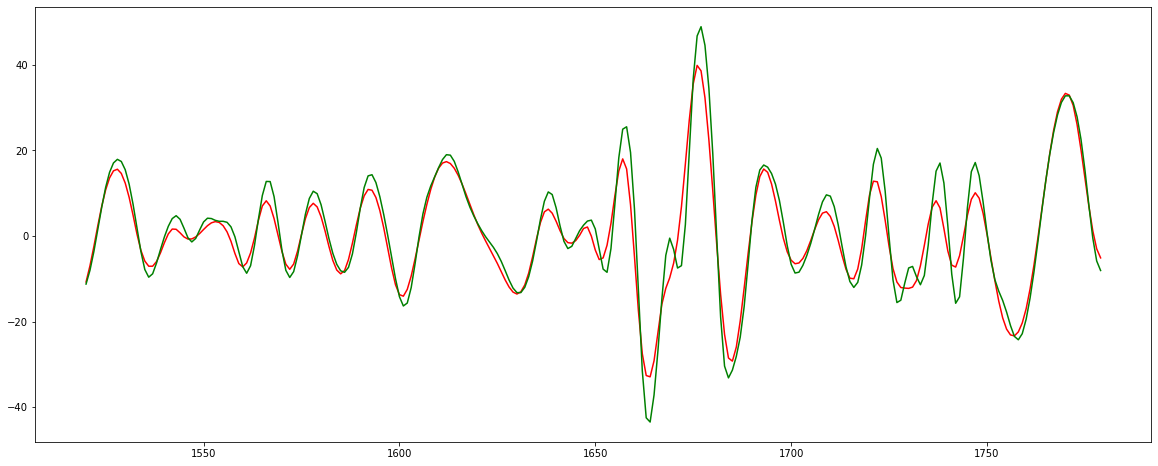

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 15:45:37.210696: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_60490_60975' and '__inference___backward_standard_lstm_60490_60975_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_61513' both implement 'lstm_373ac972-ea2d-4a03-9f6c-077359efc3c0' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.8084

2022-06-20 15:45:40.237415: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_62074' and '__inference_standard_lstm_61963_specialized_for_sequential_5_lstm_11_StatefulPartitionedCall_at___inference_distributed_function_62292' both implement 'lstm_96efdef0-adb3-4ca5-ab8e-eec469529a77' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 0.8105 - val_loss: 1.3044
Epoch 2/50
1500/1500 [==============================] - 1s 962us/sample - loss: 0.6713 - val_loss: 1.0381
Epoch 3/50
1500/1500 [==============================] - 1s 965us/sample - loss: 0.4715 - val_loss: 0.7089
Epoch 4/50
1500/1500 [==============================] - 1s 963us/sample - loss: 0.2686 - val_loss: 0.5360
Epoch 5/50
1500/1500 [==============================] - 1s 961us/sample - loss: 0.2105 - val_loss: 0.4657
Epoch 6/50
1500/1500 [==============================] - 1s 960us/sample - loss: 0.1762 - val_loss: 0.4087
Epoch 7/50
1500/1500 [==============================] - 1s 973us/sample - loss: 0.1474 - val_loss: 0.3653
Epoch 8/50
1500/1500 [==============================] - 1s 954us/sample - loss: 0.1262 - val_loss: 0.3277
Epoch 9/50
1500/1500 [==============================] - 1s 958us/sample - loss: 0.1094 - val_loss: 0.2964
Epoch 10/50
1500/1500 [==============================] - 1s

2022-06-20 15:47:22.430986: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_68345_specialized_for_sequential_5_lstm_11_StatefulPartitionedCall_at___inference_distributed_function_68647' and '__inference_cudnn_lstm_with_fallback_68456' both implement 'lstm_63655983-d400-4ef1-90e6-81fa0f09250f' but their signatures do not match.


Train RMSE: 3.26
Test RMSE: 6.02


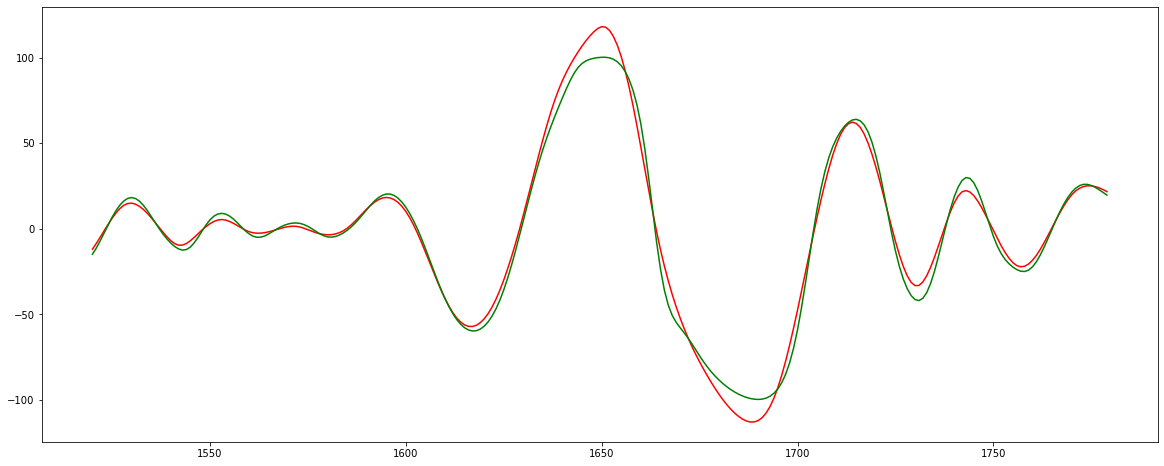

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 15:47:24.706659: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_72094_72276' and '__inference___backward_standard_lstm_72389_72874_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_73412' both implement 'lstm_fbd4ea70-fb2d-4f25-9825-8165242e5008' but their signatures do not match.


1472/1500 [============================>.] - ETA: 0s - loss: 0.7637

2022-06-20 15:47:33.778191: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_73862' and '__inference_standard_lstm_73862_specialized_for_sequential_6_lstm_13_StatefulPartitionedCall_at___inference_distributed_function_74191' both implement 'lstm_bd86ee32-fd0b-42c4-8096-e5076b67846c' but their signatures do not match.


1500/1500 [==============================] - 11s 7ms/sample - loss: 0.7610 - val_loss: 1.0011
Epoch 2/50
1500/1500 [==============================] - 7s 5ms/sample - loss: 0.4247 - val_loss: 0.6129
Epoch 3/50
1500/1500 [==============================] - 9s 6ms/sample - loss: 0.2136 - val_loss: 0.5210
Epoch 4/50
1500/1500 [==============================] - 9s 6ms/sample - loss: 0.1712 - val_loss: 0.4480
Epoch 5/50
1500/1500 [==============================] - 9s 6ms/sample - loss: 0.1362 - val_loss: 0.3864
Epoch 6/50
1500/1500 [==============================] - 10s 7ms/sample - loss: 0.1048 - val_loss: 0.3212
Epoch 7/50
1500/1500 [==============================] - 14s 9ms/sample - loss: 0.0752 - val_loss: 0.2438
Epoch 8/50
1500/1500 [==============================] - 10s 7ms/sample - loss: 0.0459 - val_loss: 0.1596
Epoch 9/50
1500/1500 [==============================] - 18s 12ms/sample - loss: 0.0281 - val_loss: 0.1284
Epoch 10/50
1500/1500 [==============================] - 28s 18ms/sam

2022-06-20 16:03:31.408609: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_80244' and '__inference_standard_lstm_80244_specialized_for_sequential_6_lstm_13_StatefulPartitionedCall_at___inference_distributed_function_80546' both implement 'lstm_5920e970-1b15-4e43-b5ea-25493f6f41d7' but their signatures do not match.


Train RMSE: 3.51
Test RMSE: 7.95


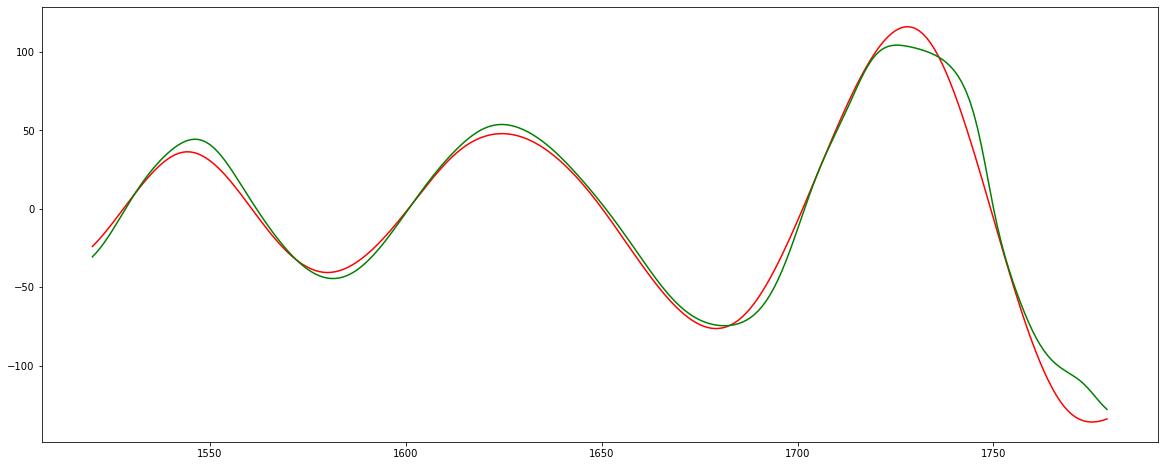

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 16:03:36.009808: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_83993_84175' and '__inference___backward_standard_lstm_84288_84773_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_85311' both implement 'lstm_dbfe3555-cbe7-4e2a-a1a1-3691be29f612' but their signatures do not match.


1472/1500 [============================>.] - ETA: 0s - loss: 0.8960

2022-06-20 16:03:40.116000: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_85761' and '__inference_standard_lstm_85761_specialized_for_sequential_7_lstm_15_StatefulPartitionedCall_at___inference_distributed_function_86090' both implement 'lstm_ff24901d-6662-49bc-ab40-3c87472c949d' but their signatures do not match.


1500/1500 [==============================] - 6s 4ms/sample - loss: 0.8975 - val_loss: 0.3249
Epoch 2/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.4063 - val_loss: 0.1622
Epoch 3/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.1054 - val_loss: 0.1032
Epoch 4/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0651 - val_loss: 0.0842
Epoch 5/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0525 - val_loss: 0.0594
Epoch 6/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0443 - val_loss: 0.0508
Epoch 7/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0388 - val_loss: 0.0548
Epoch 8/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0355 - val_loss: 0.0509
Epoch 9/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.0329 - val_loss: 0.0414
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample - lo

2022-06-20 16:09:00.177508: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_92254' and '__inference_standard_lstm_92143_specialized_for_sequential_7_lstm_15_StatefulPartitionedCall_at___inference_distributed_function_92445' both implement 'lstm_a38bc80e-a788-4ffa-92ed-ac3760e38c49' but their signatures do not match.


Train RMSE: 1.64
Test RMSE: 1.63


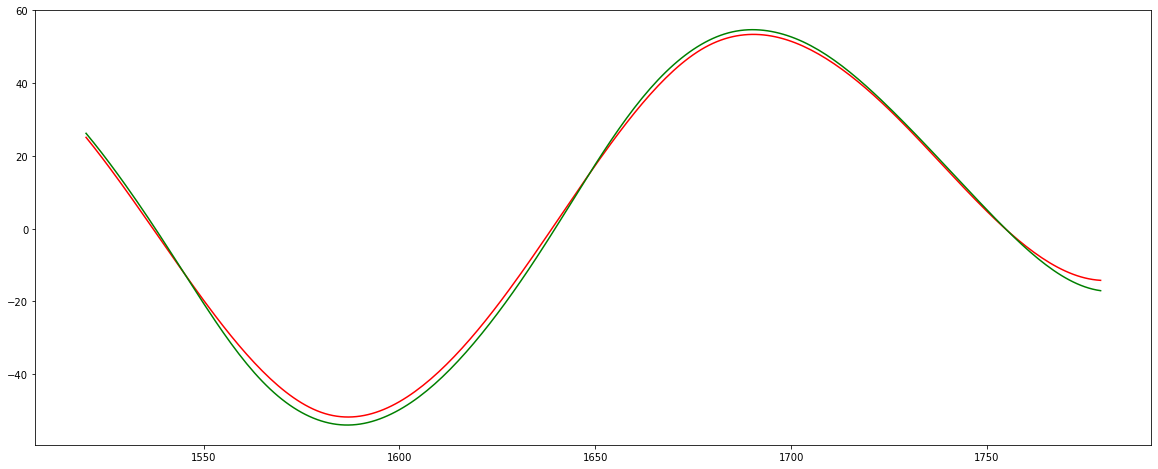

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 16:09:05.758054: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_95892_96074' and '__inference___backward_standard_lstm_96187_96672_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_97210' both implement 'lstm_33f48150-0e72-4058-a6b0-706e42ce7a63' but their signatures do not match.


1472/1500 [============================>.] - ETA: 0s - loss: 0.8954

2022-06-20 16:09:13.567632: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_97660_specialized_for_sequential_8_lstm_17_StatefulPartitionedCall_at___inference_distributed_function_97989' and '__inference_cudnn_lstm_with_fallback_97771' both implement 'lstm_9c681613-157e-4f3b-8395-d614b5f0a4ae' but their signatures do not match.


1500/1500 [==============================] - 10s 7ms/sample - loss: 0.8890 - val_loss: 0.1062
Epoch 2/50
1500/1500 [==============================] - 233s 155ms/sample - loss: 0.2250 - val_loss: 0.0571
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/sample - loss: 0.0554 - val_loss: 0.0241
Epoch 4/50
1500/1500 [==============================] - 14s 9ms/sample - loss: 0.0402 - val_loss: 0.0177
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/sample - loss: 0.0313 - val_loss: 0.0168
Epoch 6/50
1500/1500 [==============================] - 2s 2ms/sample - loss: 0.0242 - val_loss: 0.0137
Epoch 7/50
1500/1500 [==============================] - 2s 2ms/sample - loss: 0.0175 - val_loss: 0.0106
Epoch 8/50
1500/1500 [==============================] - 2s 2ms/sample - loss: 0.0119 - val_loss: 0.0084
Epoch 9/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0076 - val_loss: 0.0068
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sampl

2022-06-20 16:17:46.070579: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_104153' and '__inference_standard_lstm_104042_specialized_for_sequential_8_lstm_17_StatefulPartitionedCall_at___inference_distributed_function_104344' both implement 'lstm_05b7af23-d5f7-4189-9dee-1bdaf68283ec' but their signatures do not match.


Train RMSE: 0.77
Test RMSE: 0.40


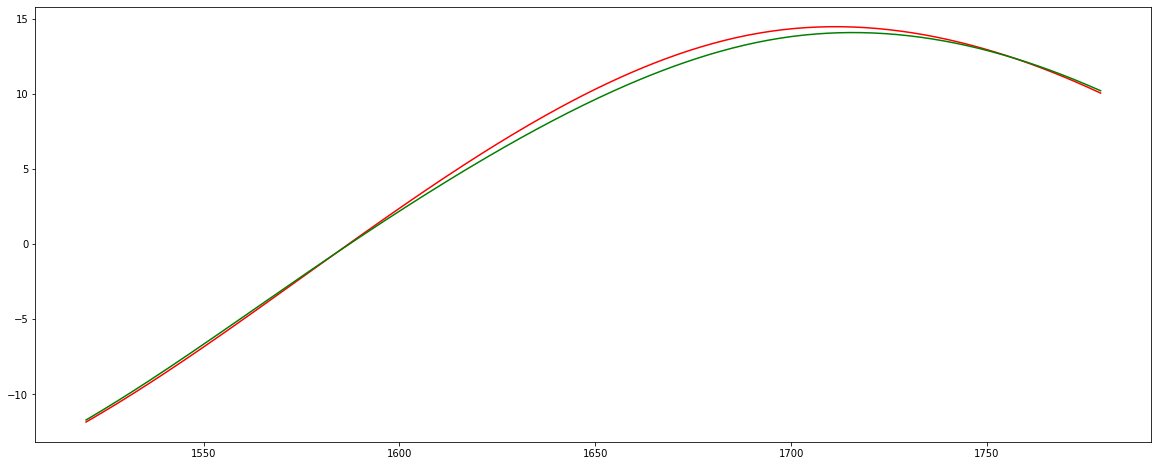

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 16:17:55.801192: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_108086_108571_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_109109' and '__inference___backward_standard_lstm_108086_108571' both implement 'lstm_74ebe86f-7a96-401b-8f66-370237c215c4' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.7204

2022-06-20 16:17:58.748839: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_109559' and '__inference_standard_lstm_109559_specialized_for_sequential_9_lstm_19_StatefulPartitionedCall_at___inference_distributed_function_109888' both implement 'lstm_520da682-ae97-40fa-814d-6bf7779339d0' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 0.7138 - val_loss: 3.2293
Epoch 2/50
1500/1500 [==============================] - 1s 994us/sample - loss: 0.6985 - val_loss: 3.1394
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.6882 - val_loss: 3.1103
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.6636 - val_loss: 3.2582
Epoch 5/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5909 - val_loss: 2.7306
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2339 - val_loss: 0.7388
Epoch 7/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0425 - val_loss: 0.3174
Epoch 8/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.0126 - val_loss: 0.1295
Epoch 9/50
1500/1500 [==============================] - 1s 994us/sample - loss: 0.0089 - val_loss: 0.1050
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/sample 

2022-06-20 16:28:00.640617: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_115941_specialized_for_sequential_9_lstm_19_StatefulPartitionedCall_at___inference_distributed_function_116243' and '__inference_cudnn_lstm_with_fallback_116052' both implement 'lstm_e47997b4-e724-4c04-9d3a-c9cdcc7f2e93' but their signatures do not match.


Train RMSE: 0.12
Test RMSE: 0.82


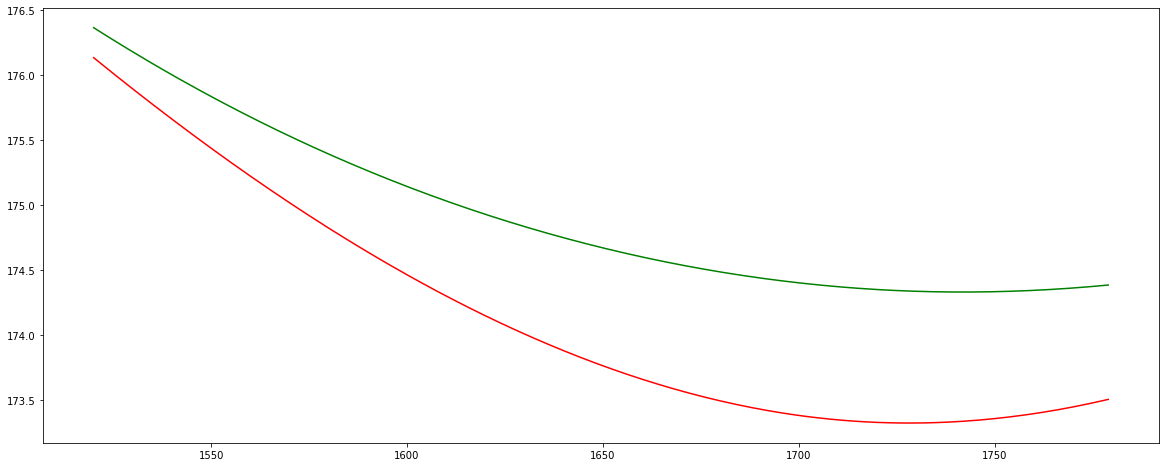

In [28]:
test_predict_df = pd.DataFrame()
for i in imfs.columns:
    test_predict_df[i] = pd.DataFrame(LSTM_model(imfs[[i]],20,1,i))

In [29]:
test_predict_df['sum'] = test_predict_df[['imf0','imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
test_predict_df['denoise1'] = test_predict_df[['imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
test_predict_df['denoise2'] = test_predict_df[['imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)

In [30]:
test_predict_df

,imf0,imf1,imf2,imf3,imf4,imf5,imf6,imf7,sum,denoise1,denoise2
0,-1.621878,1.107153,-11.246597,-14.867521,-30.604614,26.194540,-11.712883,176.367554,133.615753,135.237640,134.130478
1,0.139667,5.231423,-8.027864,-11.198580,-27.953981,24.889185,-11.559270,176.348419,147.869003,147.729340,142.497910
2,1.884733,5.882110,-3.638361,-6.954536,-24.941383,23.557281,-11.404347,176.329407,160.714905,158.830170,152.948059
3,1.533691,1.369991,1.476994,-2.375991,-21.601173,22.199886,-11.248156,176.310501,167.665741,166.132050,164.762054
4,-1.326067,-3.306119,6.691881,2.252142,-17.978735,20.818203,-11.090714,176.291672,172.352264,173.678329,176.984451
...,...,...,...,...,...,...,...,...,...,...,...
255,-0.895198,2.564099,15.401317,25.305471,-116.779510,-15.997773,10.658890,174.375061,94.632355,95.527557,92.963455
256,0.586805,7.465514,7.211407,24.215996,-119.751259,-16.343416,10.548359,174.377686,88.311096,87.724289,80.258774
257,-0.840121,13.540024,-0.454620,22.818054,-122.718353,-16.634897,10.436300,174.380386,80.526779,81.366898,67.826874
258,0.548760,-1.273840,-5.846807,21.262077,-125.481522,-16.870884,10.322718,174.383163,57.043663,56.494911,57.768745


In [61]:
testScore_sum = math.sqrt(mean_squared_error(CGMS_df['SensorGLU'][1520:], test_predict_df['sum']))
print('Test SUM RMSE: %.2f' % (testScore_sum))

testScore_denoise1 = math.sqrt(mean_squared_error(CGMS_df['SensorGLU'][1520:], test_predict_df['denoise1']))
print('Test Denoise1 RMSE: %.2f' % (testScore_denoise1))

testScore_denoise2 = math.sqrt(mean_squared_error(CGMS_df['SensorGLU'][1520:], test_predict_df['denoise2']))
print('test Denoise2 RMSE: %.2f' % (testScore_denoise2))

Test SUM RMSE: 15.03
Test Denoise1 RMSE: 14.82
test Denoise2 RMSE: 16.58


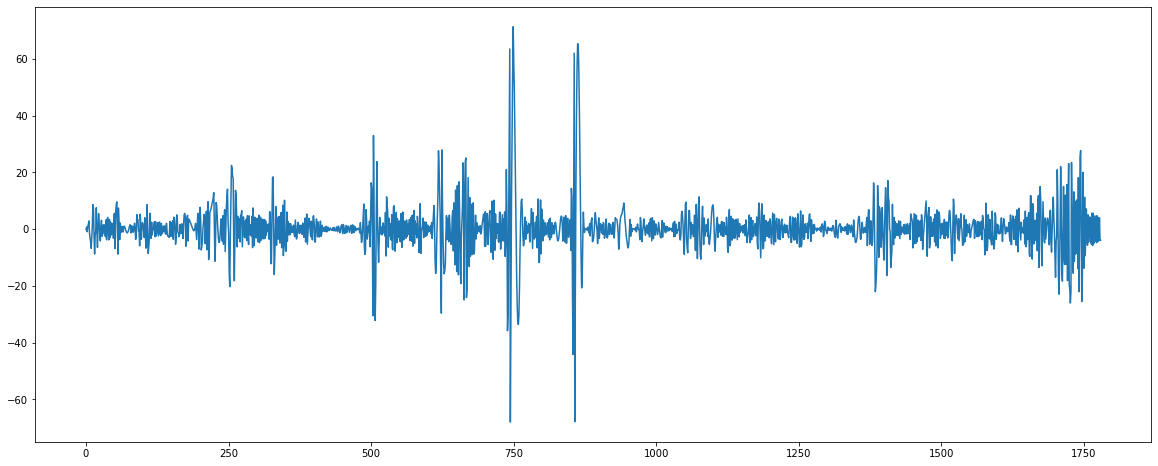

In [64]:
plt.figure(figsize=(20,8))
plt.plot(imfs['imf0'])

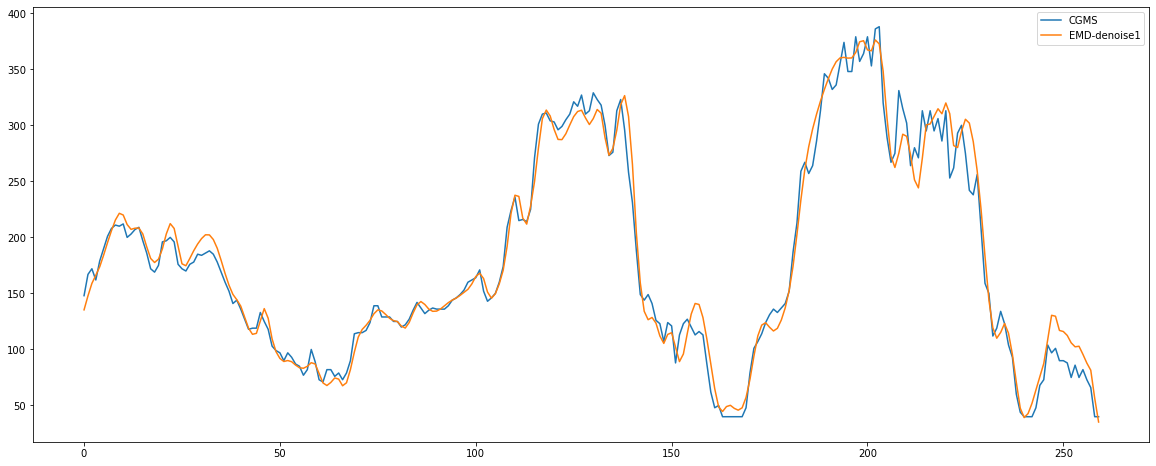

In [52]:
plt.figure(figsize=(20,8))
plt.plot(y_test,label = 'CGMS')
#plt.plot(test_predict_df['sum'],label = 'EMD')
plt.plot(test_predict_df['denoise1'],label = 'EMD-denoise1')
#plt.plot(test_predict_df['denoise2'],label = 'EMD-denoise2')
plt.legend()

# denoise data and generat data + LSTM

In [32]:
denoise_df = pd.DataFrame()
denoise_df['denoise1'] = imfs[['imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
denoise_df['denoise2'] = imfs[['imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)
denoise_df

,denoise1,denoise2
0,40.102581,44.046535
1,39.234574,43.828908
2,40.921463,43.795436
3,44.036228,43.969034
4,47.440220,44.382706
...,...,...
1775,77.847714,73.253824
1776,76.994592,66.062032
1777,62.042091,59.654437
1778,43.964227,54.795375


Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 16:28:45.799668: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_119985_120470' and '__inference___backward_standard_lstm_119985_120470_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_121008' both implement 'lstm_59d6c539-a60d-40bd-8924-8d92c3eab7ac' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.9939

2022-06-20 16:28:49.024874: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_121569' and '__inference_standard_lstm_121458_specialized_for_sequential_10_lstm_21_StatefulPartitionedCall_at___inference_distributed_function_121787' both implement 'lstm_5bc1a967-999b-47d6-b617-447aff47e847' but their signatures do not match.


1500/1500 [==============================] - 5s 3ms/sample - loss: 0.9890 - val_loss: 0.8694
Epoch 2/50
1500/1500 [==============================] - 1s 987us/sample - loss: 0.9192 - val_loss: 0.7665
Epoch 3/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.5971 - val_loss: 0.6052
Epoch 4/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.3742 - val_loss: 0.4849
Epoch 5/50
1500/1500 [==============================] - 1s 995us/sample - loss: 0.3146 - val_loss: 0.3925
Epoch 6/50
1500/1500 [==============================] - 2s 1ms/sample - loss: 0.2745 - val_loss: 0.3157
Epoch 7/50
1500/1500 [==============================] - 1s 965us/sample - loss: 0.2332 - val_loss: 0.2496
Epoch 8/50
1500/1500 [==============================] - 1s 955us/sample - loss: 0.1964 - val_loss: 0.2067
Epoch 9/50
1500/1500 [==============================] - 1s 967us/sample - loss: 0.1766 - val_loss: 0.1776
Epoch 10/50
1500/1500 [==============================] - 2s 1ms/s

2022-06-20 16:38:53.736356: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_127840_specialized_for_sequential_10_lstm_21_StatefulPartitionedCall_at___inference_distributed_function_128142' and '__inference_cudnn_lstm_with_fallback_127951' both implement 'lstm_41c7fd9d-fdc8-41ca-a4f1-6a62d59388eb' but their signatures do not match.


Train RMSE: 15.10
Test RMSE: 18.94


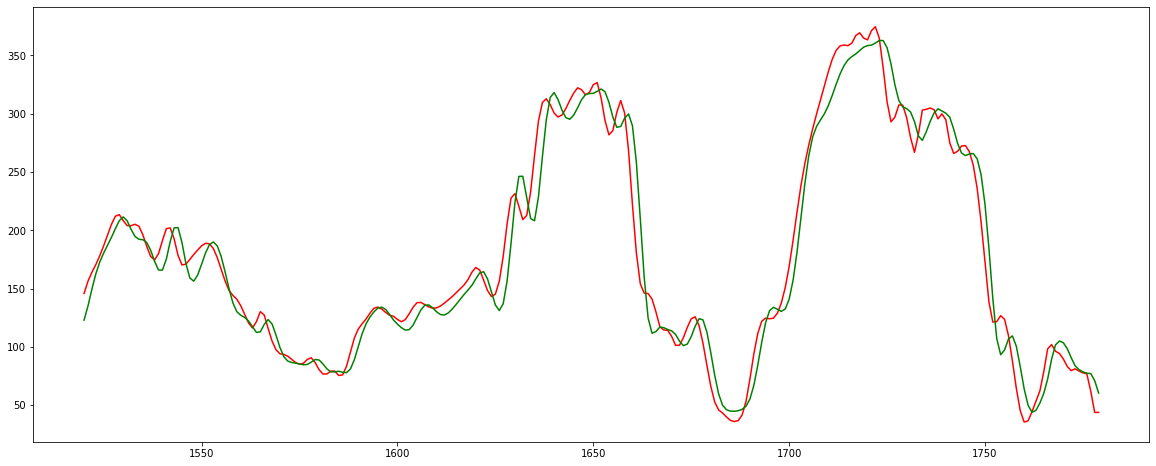

Train on 1500 samples, validate on 260 samples
Epoch 1/50


2022-06-20 16:39:03.031350: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_131884_132369' and '__inference___backward_standard_lstm_131884_132369_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_132907' both implement 'lstm_be4bb9fb-20b6-433d-be01-f16904a03001' but their signatures do not match.


1440/1500 [===========================>..] - ETA: 0s - loss: 0.9954

2022-06-20 16:39:05.950098: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_133357_specialized_for_sequential_11_lstm_23_StatefulPartitionedCall_at___inference_distributed_function_133686' and '__inference_cudnn_lstm_with_fallback_133468' both implement 'lstm_1e85ab1a-a728-409c-b803-cab5e33cf945' but their signatures do not match.


1500/1500 [==============================] - 5s 4ms/sample - loss: 0.9941 - val_loss: 0.8984
Epoch 2/50
1500/1500 [==============================] - 1s 970us/sample - loss: 0.9668 - val_loss: 0.8655
Epoch 3/50
1500/1500 [==============================] - 1s 959us/sample - loss: 0.8121 - val_loss: 0.5729
Epoch 4/50
1500/1500 [==============================] - 1s 962us/sample - loss: 0.4041 - val_loss: 0.5981
Epoch 5/50
1500/1500 [==============================] - 1s 966us/sample - loss: 0.3437 - val_loss: 0.5246
Epoch 6/50
1500/1500 [==============================] - 1s 962us/sample - loss: 0.3171 - val_loss: 0.4934
Epoch 7/50
1500/1500 [==============================] - 12s 8ms/sample - loss: 0.2811 - val_loss: 0.4103
Epoch 8/50
1500/1500 [==============================] - 3s 2ms/sample - loss: 0.2400 - val_loss: 0.3279
Epoch 9/50
1500/1500 [==============================] - 9s 6ms/sample - loss: 0.1923 - val_loss: 0.2847
Epoch 10/50
1500/1500 [==============================] - 4s 3ms/

2022-06-20 16:46:06.257158: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_139739_specialized_for_sequential_11_lstm_23_StatefulPartitionedCall_at___inference_distributed_function_140041' and '__inference_cudnn_lstm_with_fallback_139850' both implement 'lstm_64b9bcc2-9fd3-4baa-acf4-e231715c2f0c' but their signatures do not match.


Train RMSE: 10.02
Test RMSE: 12.59


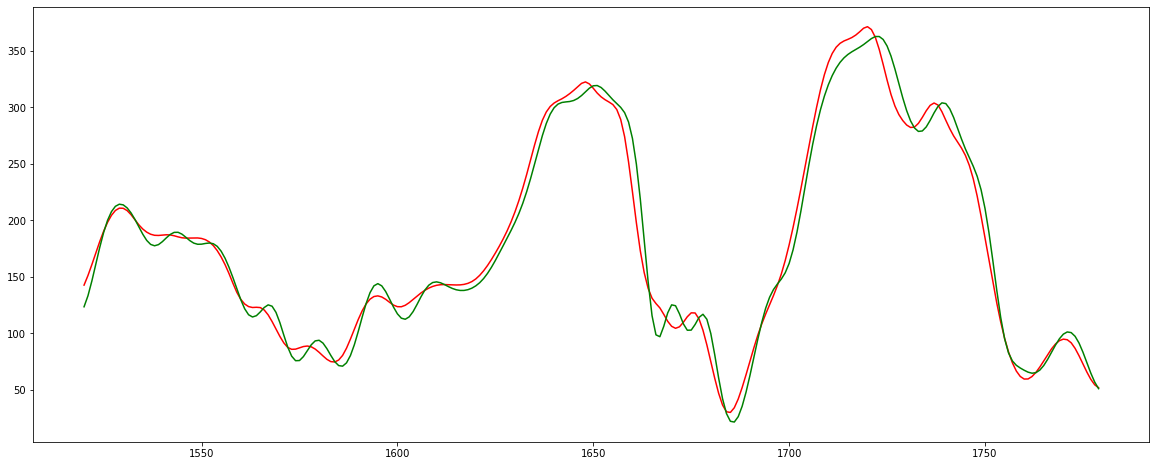

In [34]:
denoise_predict_df = pd.DataFrame()
for i in denoise_df.columns:
    denoise_predict_df[i] = pd.DataFrame(LSTM_model(denoise_df[[i]],20,1,i))

In [35]:
denoise_predict_df

,denoise1,denoise2
0,122.916153,123.596855
1,135.002136,133.348679
2,149.432907,146.474792
3,162.552353,161.260178
4,172.685013,176.012650
...,...,...
255,78.559898,83.491165
256,77.486954,74.255447
257,77.062500,65.058868
258,71.114296,57.070480


In [36]:
testScore_sum_denoise1 = math.sqrt(mean_squared_error(CGMS_df['SensorGLU'][1520:], denoise_predict_df['denoise1']))
print('Test RMSE: %.2f' % (testScore_sum_denoise1))

testScore_sum_denoise2 = math.sqrt(mean_squared_error(CGMS_df['SensorGLU'][1520:], denoise_predict_df['denoise2']))
print('test RMSE: %.2f' % (testScore_sum_denoise2))

Test RMSE: 21.41
test RMSE: 19.34


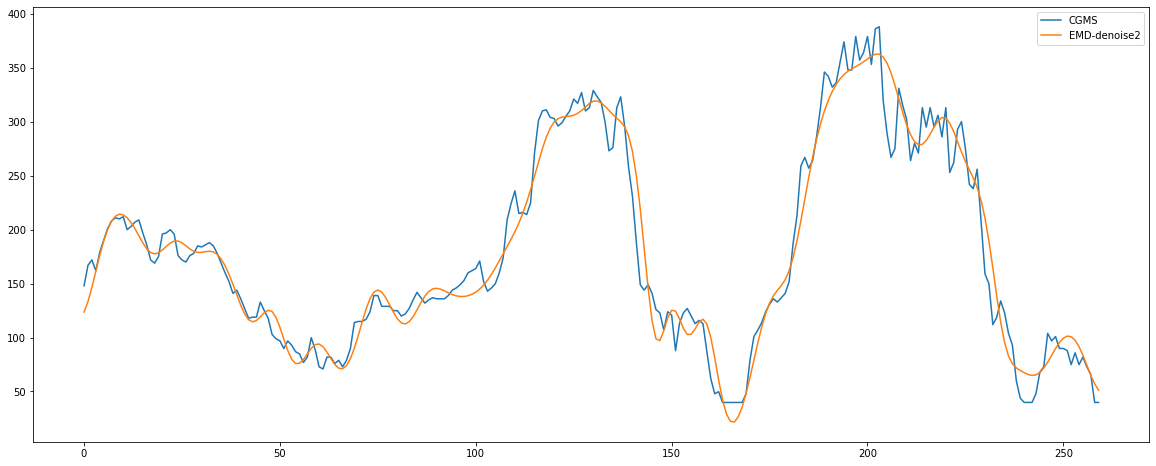

In [38]:
plt.figure(figsize=(20,8))
plt.plot(y_test,label = 'CGMS')
#plt.plot(denoise_predict_df['denoise1'],label = 'EMD-denoise1')
plt.plot(denoise_predict_df['denoise2'],label = 'EMD-denoise2')
plt.legend()

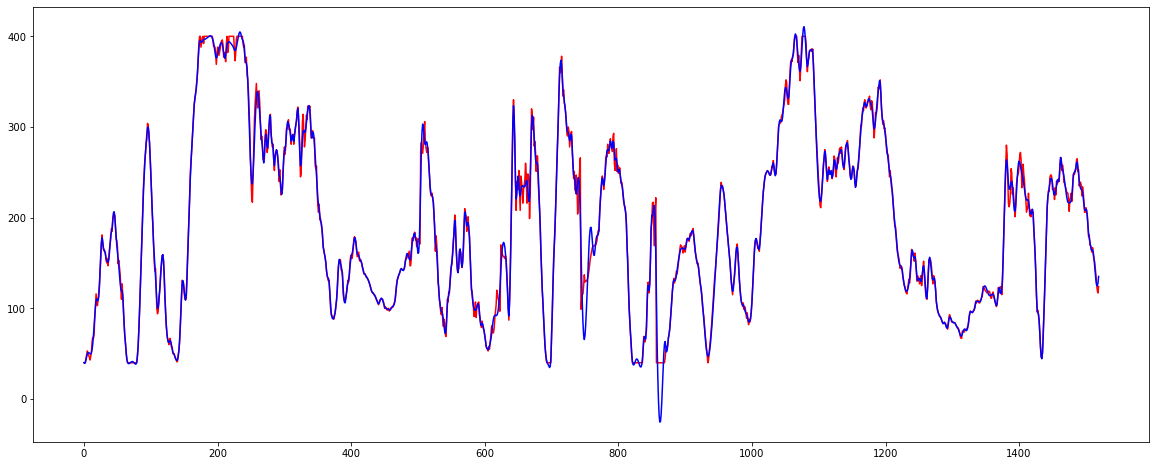

In [50]:
plt.figure(figsize = (20,8))
plt.plot(CGMS_df['SensorGLU'][:1520],'red')
plt.plot(imfs[['imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)[:1520],'blue')
#plt.plot(imfs[['imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)[:1520],'blue')



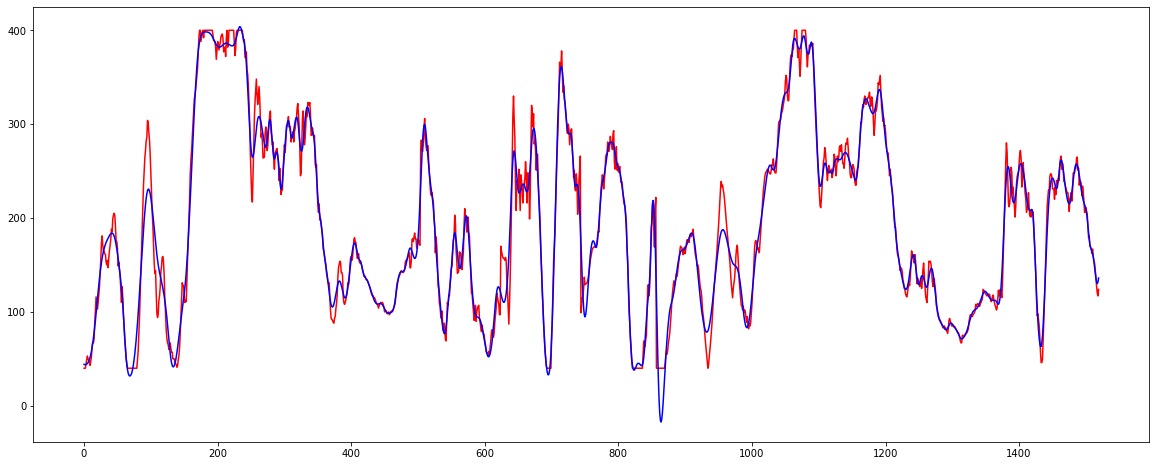

In [51]:
plt.figure(figsize = (20,8))
plt.plot(CGMS_df['SensorGLU'][:1520],'red')
#plt.plot(imfs[['imf1','imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)[:1520],'blue')
plt.plot(imfs[['imf2','imf3','imf4','imf5','imf6','imf7']].sum(axis = 1)[:1520],'blue')